In [ ]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning
import pytorch_lightning as pl

In [4]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda

device = 'cuda' if torch.cuda.is_available() else 'cpu'
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [3]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 4.1 MB/s eta 0:00:00


In [5]:
from einops.layers.torch import Reduce

In [6]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
train_dataset, val_dataset = random_split(training_data, [55000, 5000])

learning_rate = 1e-3
batch_size = 128
epochs = 10

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 314488629.01it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 12463802.22it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 121472079.89it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11332854.71it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [7]:
data, label = next(iter(train_dataloader))

In [8]:
data.shape #[batch_size, channel, width, height]

torch.Size([128, 1, 28, 28])

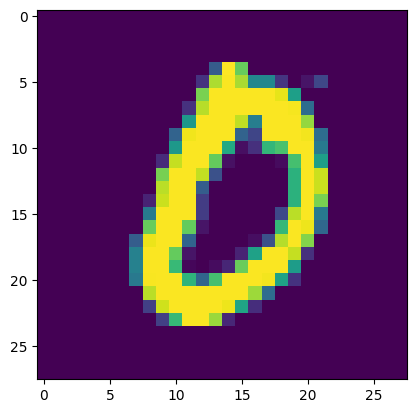

In [11]:
plt.imshow(data[100].reshape(28,28))

In [12]:
label

tensor([9, 3, 5, 4, 7, 4, 9, 6, 8, 8, 7, 4, 8, 9, 4, 0, 6, 8, 9, 9, 3, 1, 3, 2,
        5, 0, 2, 1, 6, 5, 5, 4, 7, 4, 1, 8, 7, 3, 3, 5, 1, 6, 0, 1, 4, 4, 0, 0,
        7, 0, 6, 7, 8, 9, 2, 1, 0, 7, 9, 2, 6, 8, 7, 7, 2, 8, 8, 5, 7, 1, 9, 3,
        1, 2, 4, 8, 6, 5, 1, 6, 5, 6, 8, 8, 5, 0, 2, 7, 2, 5, 8, 7, 7, 7, 2, 7,
        8, 8, 7, 7, 0, 2, 9, 5, 5, 4, 6, 6, 2, 3, 3, 1, 5, 5, 1, 8, 8, 7, 6, 2,
        0, 7, 3, 9, 2, 1, 4, 7])

In [13]:
data[100].shape

torch.Size([1, 28, 28])

In [14]:
project = nn.Conv2d(1, 16, kernel_size= 4, stride=4)
#in_chan = 1
#self.emb_size = Channel * Patch Size * Patch Size = 1 * 4 * 4 = 16
#Kernel Size = Patch Size 
#Stride = Patch Size
project(data[0].unsqueeze(0)).shape

torch.Size([1, 16, 7, 7])

In [15]:
class EmbeddingLayer(nn.Module):
    def __init__(self,in_chan, img_size, patch_size,batch_size=128):
        super().__init__()
        self.num_patches = int(img_size / pow(patch_size, 2)) # 49
        self.emb_size = in_chan * patch_size * patch_size # 16
        self.project = nn.Conv2d(in_chan, self.emb_size, kernel_size= patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1,1,self.emb_size))
        self.positions = nn.Parameter(torch.randn(self.num_patches+ 1, self.emb_size)) # [50,16]
    
 
    def forward(self, x):
        x = self.project(x)
        x = x.view(-1, 49, 16) # [batch_size, 49, 16]
        repeat_cls = self.cls_token.repeat(x.size()[0],1,1) #[batch_size, 1 , 16]
        x = torch.cat((repeat_cls, x), dim=1)
        x += self.positions
        return x

In [16]:
class Multihead(nn.Module):
    def __init__(self, emb_size, num_heads):
        super().__init__()
        self.multiheadattention = nn.MultiheadAttention(emb_size, num_heads, batch_first = True, dropout=0.2)
        self.query = nn.Linear(emb_size, emb_size)
        self.key = nn.Linear(emb_size, emb_size)
        self.value = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        attn_output, attention = self.multiheadattention(query, key, value)
        return attn_output, attention

In [17]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion = 4, drop_p = 0.2):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size)
        )

In [18]:
class VIT(nn.Module):
    def __init__(self,emb_size = 16):
        super().__init__()
        self.embedding_layer = EmbeddingLayer(1, 28*28, 4)
        self.Multihead = Multihead(emb_size, 8)
        self.FFB = FeedForwardBlock(emb_size)
        self.norm = nn.LayerNorm(emb_size)
        
    def forward(self, x):
        x = self.embedding_layer(x)
        
        norm_x = self.norm(x)
        multihead_output, attention = self.Multihead(norm_x)
        
        #residual Function
        output = multihead_output + x
        
        norm_output = self.norm(output)
        FFB = self.FFB(norm_output)
        
        final_out = FFB + output
        
        return final_out, attention

In [19]:
class TransformerEncoder(nn.Module):
    def __init__(self, n_layers: 5, ):
        super().__init__()
        self.layers = nn.ModuleList([VIT() for _ in range(n_layers)])
        
    def forward(self, x):
        for layer in self.layers:
            final_out, attention = layer(x)
            
        return final_out

In [20]:
import torchmetrics
from torchmetrics import Accuracy
ac = Accuracy(task="multiclass", num_classes = 10).to('cuda')

In [27]:
class VIT_Encoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.loss = []
        self.Encoder = nn.Sequential(
            TransformerEncoder(n_layers = 5),
            #Reduce('b n e -> b e', reduction='mean')
        )
        self.final_layer = nn.Linear(16, 10)
        self.val_loss = []
        self.acc = []
        self.test_acc =[]
        
    def forward(self, x):
        x = self.Encoder(x)
        cls_token_final = x[:,0]
        #(cls_token_final.shape)
        cls_token_final = self.final_layer(cls_token_final)
        return cls_token_final
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits,y)

        self.loss.append(loss.item())
        return loss 
    
    def on_train_epoch_end(self):
        mean_loss = sum(self.loss) / 430
        print(f'traing_loss :{mean_loss}')
        self.loss = []
        self.acc = []
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits,y)
        self.val_loss.append(loss.item())
        acc = ac(logits, y)
        self.acc.append(acc)
        return loss 
    
    def on_validation_epoch_end(self):
        mean_loss = sum(self.val_loss) / 40
        mean_acc = sum(self.acc)/ 40
        print(f'val loss :{mean_loss}, val_acc : {mean_acc}')

        self.val_loss = []
        self.acc = []
        self.log("val_loss", mean_loss)
        
    def test_dataloader(self):
        return test_dataloader
        
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = ac(logits, y)
        self.test_acc.append(acc)
        
    def on_test_epoch_end(self):
        mean_acc = sum(self.test_acc)/ 79
        print(mean_acc)
            
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)       

In [28]:
gpus = torch.cuda.device_count()
gpus

1

In [29]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
early_stop_callback = EarlyStopping(monitor='val_loss', mode ='min', patience=5)

In [31]:
model = VIT_Encoder()
trainer = pl.Trainer(max_epochs=50, accelerator='gpu', devices=1, callbacks=[early_stop_callback])
trainer.fit(model, train_dataloader, val_dataloaders = val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type       | Params
-------------------------------------------
0 | Encoder     | Sequential | 25.8 K
1 | final_layer | Linear     | 170   
-------------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.104     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

val loss :0.14497173428535462, val_acc : 0.0054687499068677425


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

val loss :0.5662674017250537, val_acc : 0.8167968988418579
traing_loss :1.5676024037738179


Validation: 0it [00:00, ?it/s]

val loss :0.3888397753238678, val_acc : 0.8759765625
traing_loss :0.5949856106625047


Validation: 0it [00:00, ?it/s]

val loss :0.3248241238296032, val_acc : 0.8960937857627869
traing_loss :0.47088996636313063


Validation: 0it [00:00, ?it/s]

val loss :0.2974674224853516, val_acc : 0.908203125
traing_loss :0.4156316927699156


Validation: 0it [00:00, ?it/s]

val loss :0.2859486941248178, val_acc : 0.9150390625
traing_loss :0.3828261423596116


Validation: 0it [00:00, ?it/s]

val loss :0.26933477260172367, val_acc : 0.9183593988418579
traing_loss :0.3598176351466844


Validation: 0it [00:00, ?it/s]

val loss :0.2526063587516546, val_acc : 0.9234375357627869
traing_loss :0.3405653507557026


Validation: 0it [00:00, ?it/s]

val loss :0.24452998340129853, val_acc : 0.9273437857627869
traing_loss :0.3266336111135261


Validation: 0it [00:00, ?it/s]

val loss :0.24993864595890045, val_acc : 0.925585925579071
traing_loss :0.31439988249263096


Validation: 0it [00:00, ?it/s]

val loss :0.2429136484861374, val_acc : 0.929882824420929
traing_loss :0.30445488358652867


Validation: 0it [00:00, ?it/s]

val loss :0.22805750817060472, val_acc : 0.931640625
traing_loss :0.2984595389213673


Validation: 0it [00:00, ?it/s]

val loss :0.2272564996033907, val_acc : 0.9326171875
traing_loss :0.2901185893561951


Validation: 0it [00:00, ?it/s]

val loss :0.22861437536776066, val_acc : 0.934765636920929
traing_loss :0.2875086234232714


Validation: 0it [00:00, ?it/s]

val loss :0.21837276220321655, val_acc : 0.935351550579071
traing_loss :0.28216170266617174


Validation: 0it [00:00, ?it/s]

val loss :0.21474602557718753, val_acc : 0.935546875
traing_loss :0.27705232998312906


Validation: 0it [00:00, ?it/s]

val loss :0.2192086312919855, val_acc : 0.936328113079071
traing_loss :0.27285135901251506


Validation: 0it [00:00, ?it/s]

val loss :0.21843921393156052, val_acc : 0.9341797232627869
traing_loss :0.26596206241222314


Validation: 0it [00:00, ?it/s]

val loss :0.20776613410562278, val_acc : 0.938281238079071
traing_loss :0.26435317287957943


Validation: 0it [00:00, ?it/s]

val loss :0.2087526921182871, val_acc : 0.9384765625
traing_loss :0.2567437795532304


Validation: 0it [00:00, ?it/s]

val loss :0.20661956127732992, val_acc : 0.9388672113418579
traing_loss :0.2545159968179326


Validation: 0it [00:00, ?it/s]

val loss :0.19917084239423274, val_acc : 0.9408203363418579
traing_loss :0.2537609941391058


Validation: 0it [00:00, ?it/s]

val loss :0.19779847450554372, val_acc : 0.939648449420929
traing_loss :0.25035004447712456


Validation: 0it [00:00, ?it/s]

val loss :0.1977892030030489, val_acc : 0.942187488079071
traing_loss :0.24779855196559153


Validation: 0it [00:00, ?it/s]

val loss :0.1982864461839199, val_acc : 0.9417968988418579
traing_loss :0.24742384703699932


Validation: 0it [00:00, ?it/s]

val loss :0.2000345790758729, val_acc : 0.9419922232627869
traing_loss :0.2426997943153215


Validation: 0it [00:00, ?it/s]

val loss :0.19001173824071885, val_acc : 0.9419922232627869
traing_loss :0.24415680637886358


Validation: 0it [00:00, ?it/s]

val loss :0.1834443474188447, val_acc : 0.945117175579071
traing_loss :0.23959048224049945


Validation: 0it [00:00, ?it/s]

val loss :0.18611655291169882, val_acc : 0.9429687857627869
traing_loss :0.23683603702242984


Validation: 0it [00:00, ?it/s]

val loss :0.1820428494364023, val_acc : 0.942187488079071
traing_loss :0.23730387013665466


Validation: 0it [00:00, ?it/s]

val loss :0.18891098108142615, val_acc : 0.9419922232627869
traing_loss :0.23254100934190805


Validation: 0it [00:00, ?it/s]

val loss :0.17656176630407572, val_acc : 0.945507824420929
traing_loss :0.23024355065683985


Validation: 0it [00:00, ?it/s]

val loss :0.17415991760790347, val_acc : 0.9453125
traing_loss :0.22933265653460524


Validation: 0it [00:00, ?it/s]

val loss :0.1818535728380084, val_acc : 0.943554699420929
traing_loss :0.22747409646940786


Validation: 0it [00:00, ?it/s]

val loss :0.17754490058869124, val_acc : 0.945507824420929
traing_loss :0.22349164692121884


Validation: 0it [00:00, ?it/s]

val loss :0.17523473631590605, val_acc : 0.9443359375
traing_loss :0.22216109969588213


Validation: 0it [00:00, ?it/s]

val loss :0.17280116118490696, val_acc : 0.9501953125
traing_loss :0.22276444159621417


Validation: 0it [00:00, ?it/s]

val loss :0.17265983801335097, val_acc : 0.945117175579071
traing_loss :0.21976074451623961


Validation: 0it [00:00, ?it/s]

val loss :0.17073347475379705, val_acc : 0.950390636920929
traing_loss :0.21974664139886235


Validation: 0it [00:00, ?it/s]

val loss :0.17367099467664956, val_acc : 0.9482421875
traing_loss :0.216922078281641


Validation: 0it [00:00, ?it/s]

val loss :0.17455903086811303, val_acc : 0.947070300579071
traing_loss :0.21712767821411755


Validation: 0it [00:00, ?it/s]

val loss :0.1690303822979331, val_acc : 0.9482421875
traing_loss :0.21409798002866812


Validation: 0it [00:00, ?it/s]

val loss :0.16520089507102967, val_acc : 0.9482421875
traing_loss :0.21170203317563202


Validation: 0it [00:00, ?it/s]

val loss :0.17239104192703963, val_acc : 0.9447265863418579
traing_loss :0.21175599475066328


Validation: 0it [00:00, ?it/s]

val loss :0.1680852584540844, val_acc : 0.948437511920929
traing_loss :0.21250831567963888


Validation: 0it [00:00, ?it/s]

val loss :0.1750709054991603, val_acc : 0.947070300579071
traing_loss :0.21111065142376478


Validation: 0it [00:00, ?it/s]

val loss :0.16211189851164817, val_acc : 0.949999988079071
traing_loss :0.21093215692008652


Validation: 0it [00:00, ?it/s]

val loss :0.16517016403377055, val_acc : 0.94921875
traing_loss :0.20878559087598048


Validation: 0it [00:00, ?it/s]

val loss :0.15962320286780596, val_acc : 0.952343761920929
traing_loss :0.20767769093603589


Validation: 0it [00:00, ?it/s]

val loss :0.16047159358859062, val_acc : 0.953125
traing_loss :0.20619977459658023


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


val loss :0.16448978893458843, val_acc : 0.947460949420929
traing_loss :0.2020782807711945


In [32]:
k = model.test_dataloader()
b, y = next(iter(k))
print(y.shape)

torch.Size([128])


In [33]:
trainer.test()

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_2/checkpoints/epoch=49-step=21500.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_2/checkpoints/epoch=49-step=21500.ckpt


Testing: 0it [00:00, ?it/s]

tensor(0.9569, device='cuda:0')


[{}]